Written by Shashwat Depali Nagar

# Comparing models with different sub-sampled datasets

Analysis done in service of Sharma et al., 2025 (Shared Google Doc linked [here](https://docs.google.com/document/d/1QuqsEp6Gn-UUQTIvXMO4D3E-iXYldk0BOeQnLR4QRDw/edit?tab=t.0))

**Date Started**: January 29, 2025

**Date Last Updated**: February 4, 2025

**Changelog**:
1. January 29, 2025 - First pass
2. February 4, 2025 - Transforming all models to linear models to make R2 directly comparable
3. February 7, 2025 - Meeting with HB. Action iterms defined below:



_Action iterms from Feb 7, 2025 meeting_
1. We are going to proceed with a linear adjusted model with model type.  Units of sample size will not be adjusted. Generate Forest plot of linear model. 
2. What would the predicted value be at 10,000 samples?
3. Perform the same analysis for MSE.


Eventually:
1. Add Neural nets as model type

In [1]:
# Loading libraries
library(dplyr) 
library(readr)
library(tidyr)
library(reshape2)
library(tibble)

library(forestmodel)

library(ggplot2)
library(cowplot)

data_path<-'/home/hmbaghda/orcd/pool/metastatic_potential/'


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: ggplot2



# Loading data

Current version received on January 24, 2025 (email thread linked [here](https://mail.google.com/mail/u/0/#all/FMfcgzQZSsCzGKBlpQXdPWsbHKjlsNGb))

In [2]:
res <- read_csv(file.path(data_path, "processed", "power_analysis_transcriptomics.csv")) %>%
  select(-1)
y_joint = read_csv(file.path(data_path, 'processed',  'metastatic_potential_joint.csv')) %>%
select(-1) 
y_proteomics = read_csv(file.path(data_path, 'processed',  'metastatic_potential_protein.csv')) %>%
select(-1) 
res <- res %>%
  filter(!(train_sample_size %in% c(nrow(y_joint), nrow(y_proteomics))))

New names:
• `` -> `...1`
Rows: 32730 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): model
dbl (7): ...1, fold, train_sample_size, train_corr, test_corr, train_mse, te...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 247 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ...1
dbl (4): CI.05, CI.95, mean, penetrance

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 248 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ...1
dbl (4): CI.05, CI.95, mean, penetrance

ℹ Use `spec()` to retrieve the full column specificatio

In [3]:
res_ann<-read_csv(file.path(data_path, "processed", "power_analysis_ann_transcriptomics.csv"))
res_ann<-res_ann[res_ann$set == 'test',]
names(res_ann)<-c('fold', 'iteration', 'train_sample_size', 'set', 'test_corr', 'test_mse')
res_ann <- res_ann %>% select(-iteration, -set)
res_ann$train_sample_size<-as.integer(gsub("^[^0-9]+", "", res_ann$train_sample_size))
res_ann$model<-'ANN'

col_names<-c('model', 'fold', 'train_sample_size', 'test_corr', 'test_mse')
res<-rbind(res[col_names], res_ann[col_names])

res$model <- factor(res$model, levels = c("svr_linear", "svr_rbf", "svr_poly", "ANN"))

Rows: 18020 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): iteration, subset, set
dbl (3): fold, r, MSE

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
df<-res

Based on Supplementary Figure _X_ (numbered _CC_ at time of writing), the variables of interest are:
1. Pearson Correlation
2. MSE

**Assumption**: Proceeding with the `test` version of each variable here.

1. Pearson Correlation --> `test_corr`
2. MSE --> `test_mse`

In [5]:
df %>%
count(model)

model,n
<fct>,<int>
svr_linear,10010
svr_rbf,10710
svr_poly,11010
ANN,9010


## 1. Linear Modeling

In [6]:
linearSVR_linear_model <- lm(
    test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_linear"
    )
)


summary(linearSVR_linear_model)  # Check model summar


Call:
lm(formula = test_corr ~ train_sample_size, data = df %>% filter(model == 
    "svr_linear"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.61920 -0.09195  0.00293  0.08581  0.35296 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       3.184e-01  2.793e-03   114.0   <2e-16 ***
train_sample_size 4.100e-04  1.155e-05    35.5   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1228 on 10008 degrees of freedom
Multiple R-squared:  0.1118,	Adjusted R-squared:  0.1118 
F-statistic:  1260 on 1 and 10008 DF,  p-value: < 2.2e-16


In [7]:
polySVR_linear_model <- lm(
    test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_poly"
    )
)


summary(polySVR_linear_model)  # Check model summar


Call:
lm(formula = test_corr ~ train_sample_size, data = df %>% filter(model == 
    "svr_poly"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.59183 -0.07989  0.00428  0.07959  0.34431 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       3.118e-01  2.579e-03  120.88   <2e-16 ***
train_sample_size 4.765e-04  1.074e-05   44.37   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1142 on 11008 degrees of freedom
Multiple R-squared:  0.1517,	Adjusted R-squared:  0.1516 
F-statistic:  1969 on 1 and 11008 DF,  p-value: < 2.2e-16


In [8]:
rbfSVR_linear_model <- lm(
    test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_rbf"
    )
)


summary(rbfSVR_linear_model)  # Check model summar


Call:
lm(formula = test_corr ~ train_sample_size, data = df %>% filter(model == 
    "svr_rbf"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.58206 -0.08678  0.00676  0.09280  0.36462 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       3.106e-01  2.798e-03  111.02   <2e-16 ***
train_sample_size 4.422e-04  1.163e-05   38.03   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1236 on 10708 degrees of freedom
Multiple R-squared:  0.119,	Adjusted R-squared:  0.1189 
F-statistic:  1446 on 1 and 10708 DF,  p-value: < 2.2e-16


In [9]:
ann_linear_model <- lm(
    test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "ANN"
    )
)


summary(ann_linear_model)  # Check model summar


Call:
lm(formula = test_corr ~ train_sample_size, data = df %>% filter(model == 
    "ANN"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.55766 -0.09341  0.01127  0.09971  0.40615 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       2.830e-01  3.173e-03   89.21   <2e-16 ***
train_sample_size 4.171e-04  1.301e-05   32.07   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1383 on 9008 degrees of freedom
Multiple R-squared:  0.1025,	Adjusted R-squared:  0.1024 
F-statistic:  1028 on 1 and 9008 DF,  p-value: < 2.2e-16


## 2. Power Modeling

$$
    Correlation = a * {train sample size}^b
$$

To linearlize this, we can transform the data:
$$
    log_{10}(Correlation) = log_{10}(a) + b *log_{10}(train sample size)
$$



____ 


With Model Type

To linearlize this, we can transform the data:
$$
    log_{10}(Correlation) = log_{10}(a) + b *log_{10}(train sample size) + c * Model Type
$$



$$
    Y = Intercept + b *log_{10}(train sample size) + c * Model Type
$$

In [10]:
linearSVR_power_model <- lm(
    log10_test_corr ~ log10_train_sample_size,
    data = df %>%
    filter(
        model == "svr_linear"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr),
        log10_train_sample_size = log10(train_sample_size)
    )
)


summary(linearSVR_power_model)  # Check model summary

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ log10_train_sample_size, data = df %>% 
    filter(model == "svr_linear") %>% mutate(log10_test_corr = log10(test_corr), 
    log10_train_sample_size = log10(train_sample_size)))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.55546 -0.08790  0.02498  0.10572  0.40349 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -0.951278   0.013202  -72.06   <2e-16 ***
log10_train_sample_size  0.236320   0.005783   40.86   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1615 on 9976 degrees of freedom
  (32 observations deleted due to missingness)
Multiple R-squared:  0.1434,	Adjusted R-squared:  0.1433 
F-statistic:  1670 on 1 and 9976 DF,  p-value: < 2.2e-16


In [11]:
polySVR_power_model <- lm(
    log10_test_corr ~ log10_train_sample_size,
    data = df %>%
    filter(
        model == "svr_poly"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr),
        log10_train_sample_size = log10(train_sample_size)
    )
)


summary(polySVR_power_model)  # Check model summary

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ log10_train_sample_size, data = df %>% 
    filter(model == "svr_poly") %>% mutate(log10_test_corr = log10(test_corr), 
    log10_train_sample_size = log10(train_sample_size)))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.15659 -0.07321  0.02120  0.09419  0.38429 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -0.99153    0.01215  -81.58   <2e-16 ***
log10_train_sample_size  0.25846    0.00531   48.68   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1487 on 10970 degrees of freedom
  (38 observations deleted due to missingness)
Multiple R-squared:  0.1776,	Adjusted R-squared:  0.1776 
F-statistic:  2369 on 1 and 10970 DF,  p-value: < 2.2e-16


In [12]:
rbfSVR_power_model <- lm(
    log10_test_corr ~ log10_train_sample_size,
    data = df %>%
    filter(
        model == "svr_rbf"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr),
        log10_train_sample_size = log10(train_sample_size)
    )
)


summary(rbfSVR_power_model)  # Check model summar

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ log10_train_sample_size, data = df %>% 
    filter(model == "svr_rbf") %>% mutate(log10_test_corr = log10(test_corr), 
    log10_train_sample_size = log10(train_sample_size)))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.86683 -0.07924  0.03038  0.11099  0.41022 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -0.956951   0.013393  -71.45   <2e-16 ***
log10_train_sample_size  0.237673   0.005855   40.60   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1636 on 10666 degrees of freedom
  (42 observations deleted due to missingness)
Multiple R-squared:  0.1338,	Adjusted R-squared:  0.1338 
F-statistic:  1648 on 1 and 10666 DF,  p-value: < 2.2e-16


In [13]:
ann_power_model <- lm(
    log10_test_corr ~ log10_train_sample_size,
    data = df %>%
    filter(
        model == "ANN"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr),
        log10_train_sample_size = log10(train_sample_size)
    )
)


summary(ann_power_model)  # Check model summary

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ log10_train_sample_size, data = df %>% 
    filter(model == "ANN") %>% mutate(log10_test_corr = log10(test_corr), 
    log10_train_sample_size = log10(train_sample_size)))

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3415 -0.0860  0.0497  0.1359  0.4523 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -1.014395   0.018119  -55.99   <2e-16 ***
log10_train_sample_size  0.242943   0.007954   30.54   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2192 on 8905 degrees of freedom
  (103 observations deleted due to missingness)
Multiple R-squared:  0.09483,	Adjusted R-squared:  0.09473 
F-statistic: 932.9 on 1 and 8905 DF,  p-value: < 2.2e-16


## 3. Exponential Modeling

Correlation = a * e<sup>train_sample_size * b</sup>



$$
    Correlation = a * e^{b * {train sample size}}
$$

To linearlize this, we can transform the data:
$$
    log_{e}(Correlation) = log_{e}(a) + b * (train sample size)
$$

In [14]:
linearSVR_exp_model <- lm(
    log10_test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_linear"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr)
    )
)

summary(linearSVR_exp_model)  # Check model summary

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ train_sample_size, data = df %>% 
    filter(model == "svr_linear") %>% mutate(log10_test_corr = log10(test_corr)))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.54238 -0.08764  0.02554  0.11096  0.35151 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -5.372e-01  3.756e-03 -143.02   <2e-16 ***
train_sample_size  5.573e-04  1.551e-05   35.93   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1642 on 9976 degrees of freedom
  (32 observations deleted due to missingness)
Multiple R-squared:  0.1146,	Adjusted R-squared:  0.1145 
F-statistic:  1291 on 1 and 9976 DF,  p-value: < 2.2e-16


In [15]:
polySVR_exp_model <- lm(
    log10_test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_poly"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr)
    )
)

summary(polySVR_exp_model)  # Check model summar

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ train_sample_size, data = df %>% 
    filter(model == "svr_poly") %>% mutate(log10_test_corr = log10(test_corr)))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.21281 -0.07397  0.02374  0.09972  0.32929 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -5.399e-01  3.443e-03 -156.81   <2e-16 ***
train_sample_size  6.227e-04  1.431e-05   43.51   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1514 on 10970 degrees of freedom
  (38 observations deleted due to missingness)
Multiple R-squared:  0.1472,	Adjusted R-squared:  0.1471 
F-statistic:  1893 on 1 and 10970 DF,  p-value: < 2.2e-16


In [16]:
rbfSVR_exp_model <- lm(
    log10_test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_rbf"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr)
    )
)

summary(rbfSVR_exp_model)  # Check model summar

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ train_sample_size, data = df %>% 
    filter(model == "svr_rbf") %>% mutate(log10_test_corr = log10(test_corr)))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.91749 -0.08022  0.03327  0.11510  0.35957 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -5.428e-01  3.775e-03  -143.8   <2e-16 ***
train_sample_size  5.763e-04  1.566e-05    36.8   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1655 on 10666 degrees of freedom
  (42 observations deleted due to missingness)
Multiple R-squared:  0.1127,	Adjusted R-squared:  0.1126 
F-statistic:  1354 on 1 and 10666 DF,  p-value: < 2.2e-16


In [17]:
ann_exp_model <- lm(
    log10_test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "ANN"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr)
    )
)

summary(ann_exp_model)  # Check model summary

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ train_sample_size, data = df %>% 
    filter(model == "ANN") %>% mutate(log10_test_corr = log10(test_corr)))

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3902 -0.0848  0.0478  0.1395  0.4036 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -5.943e-01  5.141e-03 -115.59   <2e-16 ***
train_sample_size  5.900e-04  2.098e-05   28.12   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2208 on 8905 degrees of freedom
  (103 observations deleted due to missingness)
Multiple R-squared:  0.08155,	Adjusted R-squared:  0.08145 
F-statistic: 790.7 on 1 and 8905 DF,  p-value: < 2.2e-16


## Calculating Performance Metrics

In [18]:
# Function to calculate performance metrics
calc_metrics <- function(model, data, ground_truth, log_transformed = FALSE) {
    
  predicted_vals <- predict(model, newdata = data)
    
  # If the model was fit in log-space, exponentiate predictions
  if (log_transformed) {
    predicted_vals <- exp(predicted_vals)
  }
  
  mse <- mean((predicted_vals - ground_truth)^2)
  rmse <- sqrt(mse)
  
  return(c(MSE = mse, RMSE = rmse))
}


In [19]:
input_models <- c("svr_linear", "svr_poly", "svr_rbf", 'ANN') # the variable names here are a little confusing
model_types <- c("linear", "power", "exp") # the variable names here are a little confusing
power_models_out = list()
flag <- 0 # Setting Sentinel

for (curr_input in input_models) {
    curr_df <- df %>%
    filter(
        model == curr_input
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr),
        log10_train_sample_size = log10(train_sample_size),
        log10_test_mse = log10(test_mse),
        fisherZ_test_corr = 0.5 * log((1 + test_corr) / (1 - test_corr)),
        log10_fisherZ_test_corr = log10(fisherZ_test_corr)
    )

    curr_r2_linear_model <- lm(
        fisherZ_test_corr ~ train_sample_size,
        data = curr_df
    )

    curr_r2_power_model <- lm(
        log10_fisherZ_test_corr ~ log10_train_sample_size,
        data = curr_df
    )
    
    curr_r2_exp_model <- lm(
        log10_fisherZ_test_corr ~ train_sample_size,
        data = curr_df
    )
    
    curr_mse_linear_model <- lm(
        test_mse ~ train_sample_size,
        data = curr_df
    )

    curr_mse_power_model <- lm(
        log10_test_mse ~ log10_train_sample_size,
        data = curr_df
    )
    
    curr_mse_exp_model <- lm(
        log10_test_mse ~ train_sample_size,
        data = curr_df
    )
    
    power_models_out[[curr_input]] = list('corr' = curr_r2_power_model, 
                                         'mse' = curr_mse_power_model)
    
    for (curr_model in model_types) {
        curr_r2_stat_model <- get(paste0("curr_r2_", curr_model, "_model"))
        
        curr_mse_stat_model <- get(paste0("curr_mse_", curr_model, "_model"))
        
        # Below, I'm calculating a lot of different linear model performance
        # metrics - but only 1 will be used for the final comparison.
        
        if (curr_model %in% c("power", "exp")) {
            curr_metrics_r2 <- calc_metrics(curr_r2_stat_model, curr_df, curr_df$test_corr, log_transformed = T) %>%
            t() %>%
            data.frame
        } else {
            curr_metrics_r2 <- calc_metrics(curr_r2_stat_model, curr_df, curr_df$test_corr) %>%
            t() %>%
            data.frame
        }
        
        curr_metrics_r2$R2 <- summary(curr_r2_stat_model)$r.squared
        curr_metrics_r2$R2_adj <- summary(curr_r2_stat_model)$adj.r.squared
        curr_metrics_r2$AIC <- AIC(curr_r2_stat_model)
        curr_metrics_r2$BIC <- BIC(curr_r2_stat_model)
        curr_metrics_r2$Input <- curr_input
        curr_metrics_r2$Model <- curr_model
        curr_metrics_r2$TargetVariable <- "R2"
        
        # Adding metrics for MSE
        
        if (curr_model %in% c("power", "exp")) {
            curr_metrics_mse <- calc_metrics(curr_mse_stat_model, curr_df, curr_df$test_corr, log_transformed = T) %>%
            t() %>%
            data.frame
        } else {
            curr_metrics_mse <- calc_metrics(curr_mse_stat_model, curr_df, curr_df$test_corr) %>%
            t() %>%
            data.frame
        }
        
        curr_metrics_mse$R2 <- summary(curr_mse_stat_model)$r.squared
        curr_metrics_mse$R2_adj <- summary(curr_mse_stat_model)$adj.r.squared
        curr_metrics_mse$AIC <- AIC(curr_mse_stat_model)
        curr_metrics_mse$BIC <- BIC(curr_mse_stat_model)
        curr_metrics_mse$Input <- curr_input
        curr_metrics_mse$Model <- curr_model
        curr_metrics_mse$TargetVariable <- "MSE"

        if (flag == 0) {
            final_df <- rbind(curr_metrics_r2, curr_metrics_mse)
            flag <- 1 # Changing Sentinel
        } else {
            final_df <- rbind(final_df, curr_metrics_r2, curr_metrics_mse)
        }
    }
}

# final_df %>%
# write_delim(file.path(data_path, 'processed', 'poweranalysis_individual_lms.txt')
#             delim = '\t')

final_df %>%
arrange(
    desc(R2_adj)
)

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”
Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”
Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”
Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


MSE,RMSE,R2,R2_adj,AIC,BIC,Input,Model,TargetVariable
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1.31831000,1.1481768,0.32569049,0.32561563,-15947.5530,-15926.2348,ANN,power,MSE
5.36852596,2.3170080,0.27151234,0.27143147,18174.2493,18195.5675,ANN,linear,MSE
1.30993744,1.1445250,0.23665024,0.23656550,-14830.0688,-14808.7506,ANN,exp,MSE
0.08807879,0.2967807,0.17738774,0.17731275,-8764.3201,-8742.4108,svr_poly,power,R2
0.08839495,0.2973129,0.14838100,0.14830337,-8384.0932,-8362.1839,svr_poly,exp,R2
0.01442252,0.1200938,0.14437838,0.14430065,-11991.7420,-11969.8223,svr_poly,linear,R2
0.08963998,0.2993994,0.14262457,0.14253863,-6324.4630,-6302.8386,svr_linear,power,R2
0.08974416,0.2995733,0.13442891,0.13434776,-6542.2140,-6520.3890,svr_rbf,power,R2
0.01658293,0.1287747,0.11599121,0.11590865,-10250.1259,-10228.2891,svr_rbf,linear,R2


In [20]:
final_df$TargetVariable[final_df$TargetVariable == 'R2'] = 'Pearson'
names(final_df)[names(final_df) == "TargetVariable"] <- "Performance.Metric"
final_df <- final_df[order(final_df$Performance.Metric, final_df$Input, final_df$Model), ]
# final_df<-final_df[c('R2_adj', 'AIC', 'BIC', 'Input', 'Model', 'Performance.Metric')]
write.csv(final_df, 
         file.path(data_path, 'processed', 'TableVV.csv'))

In [21]:
aggregate(R2_adj ~ Model + Performance.Metric, data = final_df, FUN = mean) %>% 
arrange(
    desc(Performance.Metric),
    desc(R2_adj)
)


Model,Performance.Metric,R2_adj
<chr>,<chr>,<dbl>
power,Pearson,0.13775408
linear,Pearson,0.11641399
exp,Pearson,0.11515040
power,MSE,0.12643356
linear,MSE,0.11396177
exp,MSE,0.09863833


In [22]:
aggregate(AIC ~ Model + Performance.Metric, data = final_df, FUN = mean)%>% 
arrange(
    desc(Performance.Metric),
    AIC
)

Model,Performance.Metric,AIC
<chr>,<chr>,<dbl>
linear,Pearson,-9670.195
power,Pearson,-5582.160
exp,Pearson,-5313.060
power,MSE,-20258.714
exp,MSE,-19917.383
linear,MSE,11923.284


In [23]:
aggregate(BIC ~ Model + Performance.Metric, data = final_df, FUN = mean)%>% 
arrange(
    desc(Performance.Metric),
    BIC
)

Model,Performance.Metric,BIC
<chr>,<chr>,<dbl>
linear,Pearson,-9648.518
power,Pearson,-5560.500
exp,Pearson,-5291.399
power,MSE,-20237.037
exp,MSE,-19895.705
linear,MSE,11944.961


In [24]:
aggregate(MSE ~ Model + Performance.Metric, data = final_df, FUN = mean)%>% 
arrange(
    desc(Performance.Metric),
    MSE
)

Model,Performance.Metric,MSE
<chr>,<chr>,<dbl>
linear,Pearson,0.01686386
power,Pearson,0.09009654
exp,Pearson,0.09041001
exp,MSE,1.03292397
power,MSE,1.03549924
linear,MSE,3.51921504


We proceed with power models, as they have the best performance for adjusted R^2, as well as for AIC/BIC for MSE. 

Visualize:

In [25]:
res_nonn <- read_csv(file.path(data_path, "processed", "power_analysis_transcriptomics.csv")) %>%
  select(-1)


New names:
• `` -> `...1`
Rows: 32730 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): model
dbl (7): ...1, fold, train_sample_size, train_corr, test_corr, train_mse, te...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [26]:
mean_value <- res_nonn %>%
  filter(train_sample_size == 433) %>%
  pull(test_corr) %>%
mean()

print(mean_value)


[1] 0.4692176


In [27]:
mean_value <- res_nonn %>%
  filter(train_sample_size == 260) %>%
  pull(test_corr) %>%
mean()

print(mean_value)


[1] 0.4381627


In [28]:
mean_value <- res_nonn %>%
  filter(train_sample_size == 216) %>%
  pull(test_corr) %>%
mean()

print(mean_value)


[1] 0.4251211


In [62]:
n_splits<-10

In [65]:
mean_value <- res_nonn %>%
  filter(train_sample_size == round((1 - (1/n_splits)) *dim(y_proteomics)[1])) %>%
  pull(test_corr) %>%
mean()

print(mean_value)


[1] 0.4216573


In [66]:
mean_value <- res_nonn %>%
  filter(train_sample_size == round((1 - (1/n_splits)) *dim(y_joint)[1])) %>%
  pull(test_corr) %>%
mean()

print(mean_value)


[1] 0.4259751


In [147]:
get_power_curve<-function(power_model, performance.metric, model){
    a = 10^power_model$coefficients[['(Intercept)']]
    b = power_model$coefficients[['log10_train_sample_size']]
    x <- seq(1, max(res$train_sample_size), length.out = 5000)  # Generate x values
    
#     actual_samples<-sapply(seq(0, max(res$train_sample_size), length=11)[2:11], function(x) round(x))
#     x<-sort(union(x, actual_samples))                       
                           
                           
    plot_df <- data.frame(train_sample_size = x, value = a * x^b)
    plot_df[['performance.metric']]<-performance.metric
    plot_df[['model']]<-model
    plot_df[['label']]<-sprintf("y = %.2fx^%.2f", a,b)
    
    plot_df
    
    return(plot_df)
}

gpc_metric_map = list('corr' = 'test_corr', 'mse' = 'test_mse')
gpc_model_map = list('svr_linear' = 'Linear SVR', 'svr_poly' = 'Polynomial SVR', 'svr_rbf' = 'RBF SVR', 
                    'ANN' = 'Single NN')

counter<-1
power_plots = list()
for (mt in names(power_models_out)){
    for (metric in c('corr', 'mse')){
        power_plots[[counter]]= get_power_curve(power_models_out[[mt]][[metric]], 
                                                performance.metric = gpc_metric_map[[metric]], 
                                                model = gpc_model_map[[mt]])
        counter<-counter + 1
    }
}
power_plots<-do.call(rbind, power_plots)

In [148]:
viz.df <- res %>% select(-fold)

# apply fisher Z transformation
viz.df<-viz.df %>%
group_by(model) %>%
mutate(fisherZ_test_corr = 0.5 * log((1 + test_corr) / (1 - test_corr))) %>%
select(-test_corr) %>% rename(test_corr = fisherZ_test_corr)

# continue formatting
viz.df<-melt(viz.df, id.vars=c('train_sample_size', 'model'), value.name = 'value', 
    variable.name = 'performance.metric')

title_map <- c("svr_linear" = "Linear SVR", 
               "svr_rbf" = "RBF SVR", 
               "svr_poly" = "Polynomial SVR", 
              'ANN' = 'Single NN')

viz.df <- viz.df %>%
  mutate(model_title = factor(model, levels = names(title_map), labels = title_map)) %>%
select(-model) %>% rename(model = model_title)

power_plots_label = power_plots
power_plots<-power_plots[names(viz.df)]

exclude.samples<- sapply(
  c(nroxw(y_joint), nrow(y_proteomics)),
  function(x) round(x * (1 - (1 / n_splits)))
)
viz.df<-viz.df %>% dplyr::filter(!(train_sample_size %in% exclude.samples))

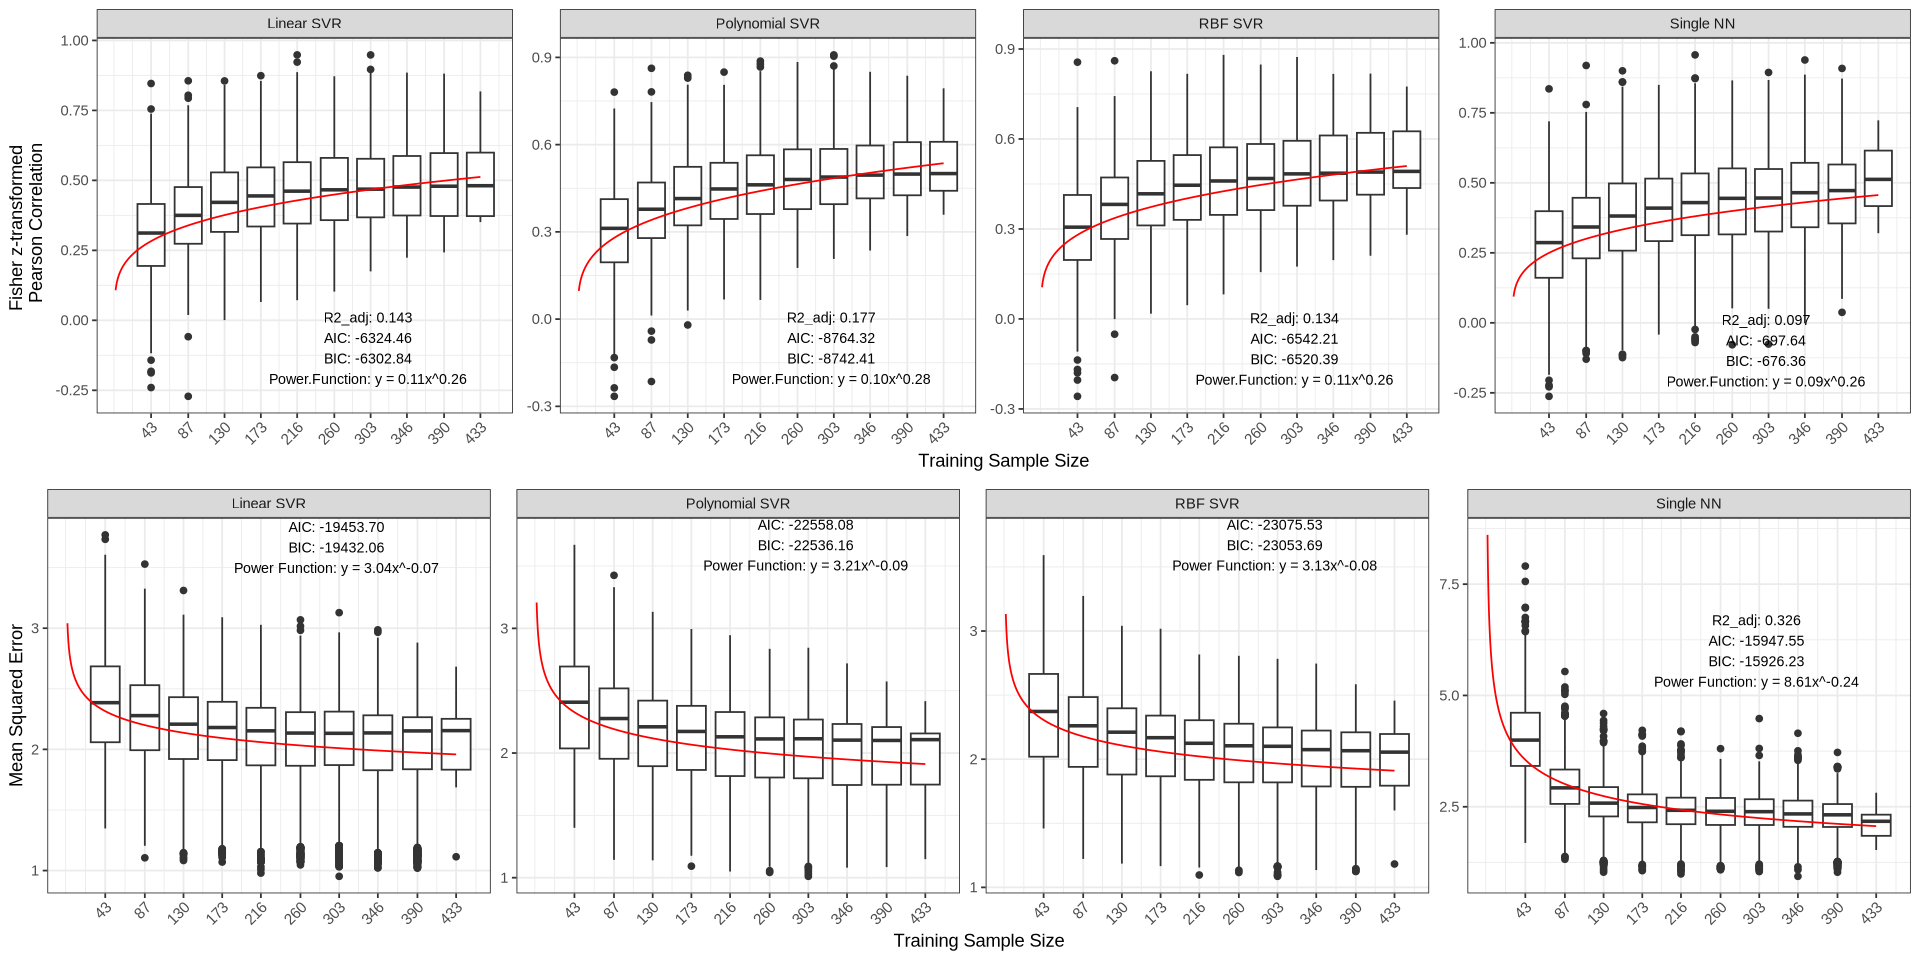

In [150]:
h = 8
w = 16

options(repr.plot.width = w, repr.plot.height = h)

model_map <- c("linearSVR" = "Linear SVR", 
               "rbfSVR" = "RBF SVR", 
               "polySVR" = "Polynomial SVR")

annotation_df<-final_df[(final_df$Model == 'power') & (final_df$Performance.Metric == 'Pearson'), ]
annotation_df =  annotation_df %>% select(-Model) %>%
mutate(model = factor(Input, levels = names(title_map), labels = title_map))

annotation_df['Power.Function']<-power_plots_label[power_plots_label$performance.metric == 'test_corr',] %>%
distinct(model, label) %>%
arrange(match(model, annotation_df$model)) %>%
select(label)

annotation_df<-annotation_df%>%
mutate(label = sprintf("R2_adj: %.3f\nAIC: %.2f\nBIC: %.2f\nPower.Function: %s", R2_adj, AIC, BIC,Power.Function)) %>%
select(model, label)
annotation_df[['x']] = 300
annotation_df[['y']] = -0.1

g1 <- ggplot() +
  geom_boxplot(data = viz.df[viz.df$performance.metric == 'test_corr',], 
               aes(x = as.numeric(train_sample_size), y = value, group = train_sample_size))+
  geom_line(data = power_plots[power_plots$performance.metric == 'test_corr',], 
            aes(x = as.numeric(train_sample_size), y = value), color = 'red') + 
# facet_grid(~model, scales = "free_y") + 
 facet_wrap(~model, ncol = 4, scales = "free_y")+
geom_text(data = annotation_df, aes(x = x, y = y, label = label), inherit.aes = T, size = 3) +
labs(x = "Training Sample Size", y = "Fisher z-transformed \n Pearson Correlation") +
theme_bw() + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
scale_x_continuous(breaks = sapply(seq(0, max(res$train_sample_size), length=11)[2:11], function(x) round(x)))

# MSE
annotation_df<-final_df[(final_df$Model == 'power') & (final_df$Performance.Metric == 'MSE'), ]
annotation_df =  annotation_df %>% select(-Model) %>%
mutate(model = factor(Input, levels = names(title_map), labels = title_map))

annotation_df['Power.Function']<-power_plots_label[power_plots_label$performance.metric == 'test_mse',] %>%
distinct(model, label) %>%
arrange(match(model, annotation_df$model)) %>%
select(label)

annotation_df<-annotation_df%>%
mutate(label = sprintf("R2_adj: %.3f\nAIC: %.2f\nBIC: %.2f\nPower Function: %s", R2_adj, AIC, BIC,Power.Function)) %>%
select(model, label)
annotation_df[['x']] = 300
annotation_df[['y']] = 3.75
annotation_df[1, c('x', 'y')] = c(300, 6)

g2 <- ggplot() +
  geom_boxplot(data = viz.df[viz.df$performance.metric == 'test_mse',], 
               aes(x = as.numeric(train_sample_size), y = value, group = train_sample_size))+
  geom_line(data = power_plots[power_plots$performance.metric == 'test_mse',], 
            aes(x = as.numeric(train_sample_size), y = value), color = 'red') + 
# facet_grid(~model, scales = "free_y") + 
facet_wrap(~model, ncol = 4, scales = "free_y")+
geom_text(data = annotation_df, aes(x = x, y = y, label = label), inherit.aes = T, size = 3) +
labs(x = "Training Sample Size", y = "Mean Squared Error") +
theme_bw() + 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
scale_x_continuous(breaks = sapply(seq(0, max(res$train_sample_size), length=11)[2:11], function(x) round(x)))

g<-plot_grid(g1, g2, ncol = 1)
                                   
ggsave(filename = file.path(data_path, "figures", "power_analysis_barplots.png"), 
       plot = g, dpi = 300, width = w, height = h)
                           
g


## Multivariable modeling to understand which model type works the best

In [151]:
curr_df <- df %>%
mutate(
    log10_test_corr = log10(test_corr),
    log10_train_sample_size = log10(train_sample_size),
    log10_test_mse = log10(test_mse),
    
    # This transformation enables a bounded variable (r is bounded by [-1,1]) to be treated as a continuous variable
    fisherZ_test_corr = 0.5 * log((1 + test_corr) / (1 - test_corr)),
    log10_fisherZ_test_corr = log10(fisherZ_test_corr)
)

multi_R2_model <- lm(
    log10_fisherZ_test_corr ~ log10_train_sample_size + model,
    data = curr_df
)

summary(multi_R2_model)

calc_metrics(multi_R2_model, curr_df, df$test_corr, log_transformed = F)

# forest_model(multi_R2_model)

# ggsave('Output/MultivariableR2Model.pdf', useDingbats = F, units = 'in', h = 6, w = 8)

Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”



Call:
lm(formula = log10_fisherZ_test_corr ~ log10_train_sample_size + 
    model, data = curr_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3541 -0.0947  0.0272  0.1216  0.5269 

Coefficients:
                         Estimate Std. Error  t value Pr(>|t|)    
(Intercept)             -0.985903   0.007837 -125.801  < 2e-16 ***
log10_train_sample_size  0.264861   0.003359   78.853  < 2e-16 ***
modelsvr_rbf            -0.002856   0.002606   -1.096    0.273    
modelsvr_poly            0.010616   0.002589    4.101 4.12e-05 ***
modelANN                -0.051654   0.002728  -18.935  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1871 on 40520 degrees of freedom
  (215 observations deleted due to missingness)
Multiple R-squared:  0.1456,	Adjusted R-squared:  0.1455 
F-statistic:  1727 on 4 and 40520 DF,  p-value: < 2.2e-16


MSE      RMSE 
0.6513500 0.8070626

In [152]:
# curr_df <- df %>%
# mutate(
#     log10_test_corr = log10(test_corr),
#     log10_train_sample_size = log10(train_sample_size),
#     log10_test_mse = log10(test_mse),
    
#     # This transformation enables a bounded variable (r is bounded by [-1,1]) to be treated as a continuous variable
#     fisherZ_test_corr = 0.5 * log((1 + test_corr) / (1 - test_corr)),
#     log10_fisherZ_test_corr = log10(fisherZ_test_corr)
# )

# multi_R2_linear_model <- lm(
#     fisherZ_test_corr ~ train_sample_size + model,
#     data = curr_df
# )

# summary(multi_R2_linear_model)

# calc_metrics(multi_R2_linear_model, curr_df, df$test_corr, log_transformed = F)

# forest_model(multi_R2_linear_model)

# # ggsave('Output/MultivariableR2Model.pdf', useDingbats = F, units = 'in', h = 6, w = 8)

In [153]:
curr_df <- df %>%
mutate(
    log10_test_corr = log10(test_corr),
    log10_train_sample_size = log10(train_sample_size),
    log10_test_mse = log10(test_mse)
)
multi_mse_model <- lm(
    log10_test_mse ~ log10_train_sample_size + model,
    data = curr_df
)

summary(multi_mse_model)

calc_metrics(multi_mse_model, curr_df, df$test_corr, log_transformed = T)

# forest_model(multi_mse_model)

# ggsave('Output/MultivariableMSEModel.pdf', useDingbats = F, units = 'in', h = 6, w = 8)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_mse ~ log10_train_sample_size + model, 
    data = curr_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.40809 -0.04675  0.01821  0.06139  0.41987 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)              0.586496   0.003805 154.146  < 2e-16 ***
log10_train_sample_size -0.118187   0.001631 -72.454  < 2e-16 ***
modelsvr_rbf            -0.007263   0.001277  -5.687 1.30e-08 ***
modelsvr_poly           -0.005549   0.001269  -4.374 1.23e-05 ***
modelANN                 0.084617   0.001334  63.430  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09186 on 40735 degrees of freedom
Multiple R-squared:  0.2293,	Adjusted R-squared:  0.2293 
F-statistic:  3030 on 4 and 40735 DF,  p-value: < 2.2e-16


MSE     RMSE 
1.022318 1.011098

Visualize:

In [154]:
viz.df<-summary(multi_R2_model)$coefficients
rownames(viz.df)<-c('Intercept', 'log10(Train Sample Size)', 'Polynomial SVR', 'RBF SVR', 'Single NN')
viz.df<-as.data.frame(viz.df) %>% tibble::rownames_to_column("term")

# g1<-ggplot(viz.df, aes(x = term, y = Estimate)) +
#   geom_point() + 
#   geom_errorbar(aes(ymin = Estimate - `Std. Error`, ymax = Estimate + `Std. Error`), width = 0.2) +
#   theme_bw() +
#   labs(x = "Predictor", y = "Estimate", title = 'Fisher z-transformed Pearson Correlation')+
# theme(plot.title = element_text(hjust = 0.5))

In [155]:
viz.df<-summary(multi_R2_model)$coefficients
rownames(viz.df)<-c('Intercept', 'log10(Train Sample Size)', 'Polynomial SVR', 'RBF SVR', 'Single NN')
viz.df<-as.data.frame(viz.df) %>% tibble::rownames_to_column("term")

g1<-ggplot(viz.df, aes(x = term, y = Estimate)) +
  geom_point() + 
  geom_errorbar(aes(ymin = Estimate - `Std. Error`, ymax = Estimate + `Std. Error`), width = 0.2) +
  theme_bw() +
  labs(x = "Predictor", y = "Estimate", title = 'Fisher z-transformed Pearson Correlation')+
theme_set(theme_bw(base_size = 16))+
theme(plot.title = element_text(hjust = 0.5), 
     axis.text.x = element_text(angle = 45, hjust = 1))


# plot the predictions
inverse_fisher_z <- function(z) {
  return((exp(2 * z) - 1) / (exp(2 * z) + 1))
}


predicted.data <- expand.grid(
  train_sample_size = seq(1, 1e4, length.out = 1e4), 
  model = c("svr_linear", "svr_poly", "svr_rbf", 'ANN')     
) %>%
  mutate(log10_train_sample_size = log10(train_sample_size))

predicted.data$log10_fisherZ_test_corr <- predict(multi_R2_model, newdata = predicted.data)
predicted.data$fisherZ_test_corr<-10^predicted.data$log10_fisherZ_test_corr
predicted.data$test_corr<-inverse_fisher_z(predicted.data$fisherZ_test_corr)

title_map <- c("svr_linear" = "Linear SVR", 
               "svr_rbf" = "RBF SVR", 
               "svr_poly" = "Polynomial SVR", 
              'ANN' = 'Single NN')

predicted.data <- predicted.data %>%
  mutate(model_title = factor(model, levels = names(title_map), labels = title_map)) %>%
select(-model) %>% rename(model = model_title)

predicted.data.corr<-predicted.data


pf<-summary(multi_R2_model)$coefficients
a=10^pf['(Intercept)', 'Estimate']
b = pf['log10_train_sample_size', 'Estimate']

m="model"
i = 'i'
m_i <- sprintf("%s[%s]", m, i)
equation = parse(text = sprintf("z == %.2f ~ N^%.2f ~ '×' ~ 10^%s", a, b, m_i))

m <- "model"
i <- "polynomial_svr"
m_i_value <- pf['modelsvr_poly','Estimate'] 
poly_m_i <- parse(text = sprintf("%s[%s] == %.2f", m, i, m_i_value))

m <- "model"
i <- "rbf_svr"
m_i_value <- pf['modelsvr_rbf','Estimate'] 
rbf_m_i <- parse(text = sprintf("%s[%s] == %.2f", m, i, m_i_value))

m <- "model"
i <- "ANN"
m_i_value <- pf['modelANN','Estimate'] 
ann_m_i <- parse(text = sprintf("%s[%s] == %.2f", m, i, m_i_value))

viz.df.main<-predicted.data
names(viz.df.main)[names(viz.df.main) == "model"] <- "Model"
g2_main<-ggplot(viz.df.main, aes(x = train_sample_size, y = test_corr, 
                               color = Model)) +
  geom_line(linewidth = 0.75) + 
  theme_bw() +
  labs(x = "Train Sample Size", y = "Pearson Correlation", title = 'Predicted Performance by Model Type')+
theme(plot.title = element_text(hjust = 0.5)) + 
theme(
  plot.title = element_text(size = rel(1.5)),
  axis.title = element_text(size = rel(1.5)),
  axis.text = element_text(size = rel(1.5)),
  legend.title = element_text(size = rel(1.5)),
  legend.text = element_text(size = rel(1.5))
)

g2<-g2_main+
geom_text(
  data = data.frame(x = 7500, y = 0.4, label = deparse(equation[[1]])),
  aes(x = x, y = y, label = label),
  parse = TRUE,
  inherit.aes = FALSE,
  size = 7.5,
  fontface = "bold"
)+
geom_text(
  data = data.frame(x = 7500, y = 0.3, label = deparse(poly_m_i[[1]])),
  aes(x = x, y = y, label = label),
  parse = TRUE,
  inherit.aes = FALSE,
  size = 7.5,
  fontface = "bold"
)+
geom_text(
  data = data.frame(x = 7500, y = 0.2, label = deparse(rbf_m_i[[1]])),
  aes(x = x, y = y, label = label),
  parse = TRUE,
  inherit.aes = FALSE,
  size = 7.5,
  fontface = "bold"
)+
geom_text(
  data = data.frame(x = 7500, y = 0.1, label = deparse(ann_m_i[[1]])),
  aes(x = x, y = y, label = label),
  parse = TRUE,
  inherit.aes = FALSE,
  size = 7.5,
  fontface = "bold"
)




# g<-plot_grid(g1, g2, ncol = 2)
# g                 
# ggsave(filename = file.path(data_path, "figures", "corr_power_analysis_model_fit.png"), 
#        plot = g, dpi = 300, width = w, height = h)


In [156]:
h = 4
w = 12

options(repr.plot.width = w, repr.plot.height = h)

viz.df<-summary(multi_mse_model)$coefficients
rownames(viz.df)<-c('Intercept', 'log10(Train Sample Size)', 'Polynomial SVR', 'RBF SVR', 'Single NN')
viz.df<-as.data.frame(viz.df) %>% tibble::rownames_to_column("term")

g1B<-ggplot(viz.df, aes(x = term, y = Estimate)) +
  geom_point() + 
  geom_errorbar(aes(ymin = Estimate - `Std. Error`, ymax = Estimate + `Std. Error`), width = 0.2) +
  theme_bw() +
  labs(x = "Predictor", y = "Estimate", title = 'Mean Squared Error')+
theme_set(theme_bw(base_size = 16))+
theme(plot.title = element_text(hjust = 0.5), 
     axis.text.x = element_text(angle = 45, hjust = 1))



predicted.data <- expand.grid(
  train_sample_size = seq(1, 1e4, length.out = 1e4), 
  model = c("svr_linear", "svr_poly", "svr_rbf", 'ANN')     
) %>%
  mutate(log10_train_sample_size = log10(train_sample_size))

predicted.data$log10_mse <- predict(multi_mse_model, newdata = predicted.data)
predicted.data$test_mse<-10^predicted.data$log10_mse

title_map <- c("svr_linear" = "Linear SVR", 
               "svr_rbf" = "RBF SVR", 
               "svr_poly" = "Polynomial SVR", 
              'ANN' = 'Single NN')

predicted.data <- predicted.data %>%
  mutate(model_title = factor(model, levels = names(title_map), labels = title_map)) %>%
select(-model) %>% rename(model = model_title)


pf<-summary(multi_mse_model)$coefficients
a=10^pf['(Intercept)', 'Estimate']
b = pf['log10_train_sample_size', 'Estimate']

m="model"
i = 'i'
m_i <- sprintf("%s[%s]", m, i)
equation = parse(text = sprintf("MSE == %.2f ~ N^%.2f ~ '×' ~ 10^%s", a, b, m_i))

m <- "model"
i <- "polynomial_svr"
m_i_value <- pf['modelsvr_poly','Estimate'] 
poly_m_i <- parse(text = sprintf("%s[%s] == %.3f", m, i, m_i_value))

m <- "model"
i <- "rbf_svr"
m_i_value <- pf['modelsvr_rbf','Estimate'] 
rbf_m_i <- parse(text = sprintf("%s[%s] == %.3f", m, i, m_i_value))

m <- "model"
i <- "ANN"
m_i_value <- pf['modelANN','Estimate'] 
ann_m_i <- parse(text = sprintf("%s[%s] == %.2f", m, i, m_i_value))

g2B<-ggplot(predicted.data, aes(x = train_sample_size, y = test_mse, 
                               color = model)) +
  geom_line() + 
  theme_bw() +
  labs(x = "Train Sample Size", y = "Mean Squared Error", title = 'Predicted Performance by Model Type')+
theme(plot.title = element_text(hjust = 0.5))+
theme(
  plot.title = element_text(size = rel(1.5)),
  axis.title = element_text(size = rel(1.5)),
  axis.text = element_text(size = rel(1.5)),
  legend.title = element_text(size = rel(1.5)),
  legend.text = element_text(size = rel(1.5))
)+
geom_text(
  data = data.frame(x = 7500, y = 3.00, label = deparse(equation[[1]])),
  aes(x = x, y = y, label = label),
  parse = TRUE,
  inherit.aes = FALSE,
  size = 7.5,
  fontface = "bold"
)+
geom_text(
  data = data.frame(x = 7500, y = 2.75, label = deparse(poly_m_i[[1]])),
  aes(x = x, y = y, label = label),
  parse = TRUE,
  inherit.aes = FALSE,
  size = 7.5,
  fontface = "bold"
)+
geom_text(
  data = data.frame(x = 7500, y = 2.5, label = deparse(rbf_m_i[[1]])),
  aes(x = x, y = y, label = label),
  parse = TRUE,
  inherit.aes = FALSE,
  size = 7.5,
  fontface = "bold"
)+
geom_text(
  data = data.frame(x = 7500, y = 2.25, label = deparse(ann_m_i[[1]])),
  aes(x = x, y = y, label = label),
  parse = TRUE,
  inherit.aes = FALSE,
  size = 7.5,
  fontface = "bold"
)


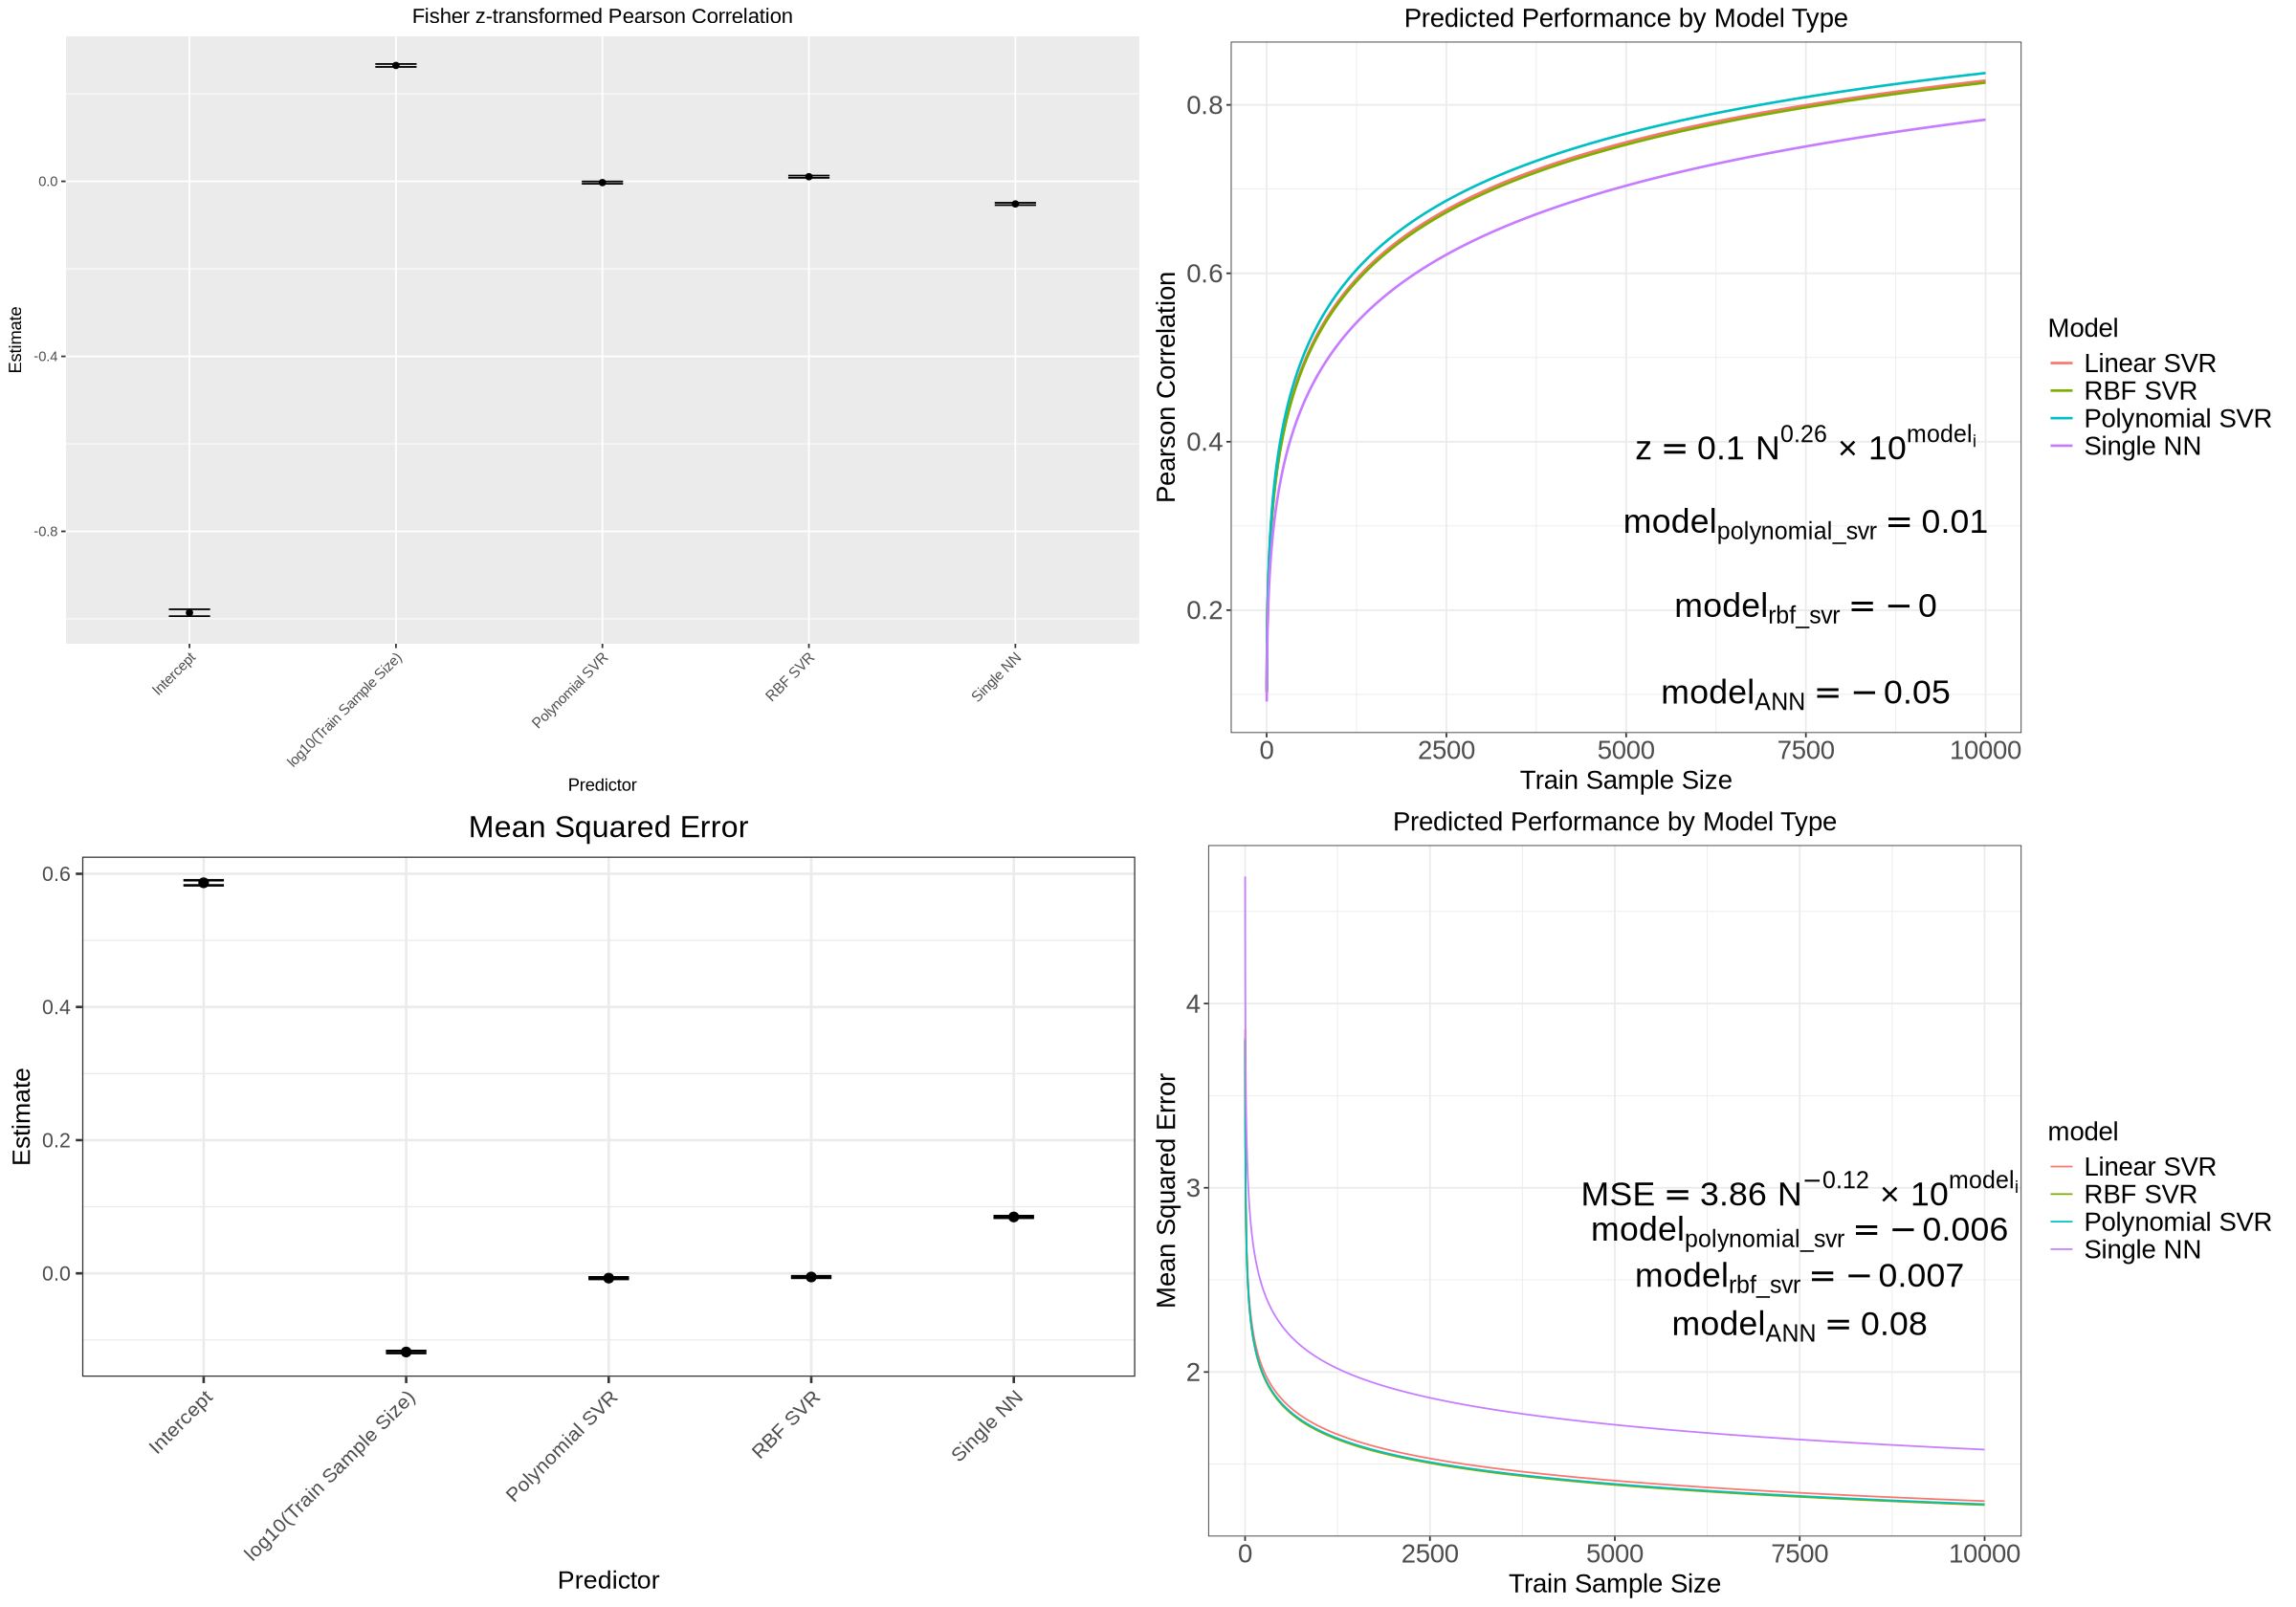

In [158]:
h = 14
w = 20

options(repr.plot.width = w, repr.plot.height = h)
g<-plot_grid(g1, g2, g1B, g2B, ncol = 2)

g                 
ggsave(filename = file.path(data_path, "figures", "power_analysis_model_fits_all.png"), 
       plot = g, dpi = 300, width = w, height = h)

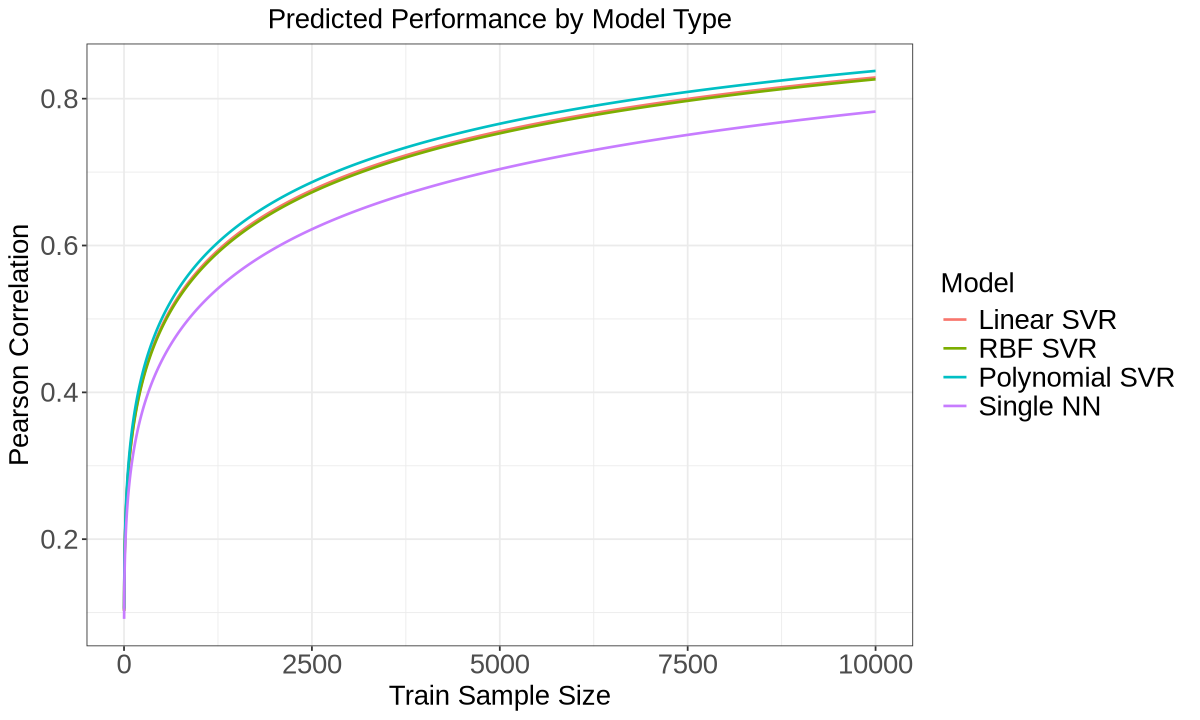

In [159]:
h = 6
w = 10

options(repr.plot.width = w, repr.plot.height = h)
g2_main

ggsave(filename = file.path(data_path, "figures", "power_analysis_predictino_pearson.png"), 
       plot = g2_main, dpi = 300, width = w, height = h)


In [160]:
pf = summary(multi_R2_model)$coefficients
pf

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-0.98590314,0.007837016,-125.800837,0.000000e+00
log10_train_sample_size,0.26486076,0.003358904,78.853322,0.000000e+00
modelsvr_rbf,-0.00285568,0.002606205,-1.095724,2.732063e-01
modelsvr_poly,0.01061640,0.002588753,4.100972,4.122197e-05
modelANN,-0.05165354,0.002727880,-18.935417,1.287294e-79


In [161]:
summary(multi_mse_model)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.586496040,0.003804803,154.146237,0.000000e+00
log10_train_sample_size,-0.118186616,0.001631188,-72.454310,0.000000e+00
modelsvr_rbf,-0.007262676,0.001277051,-5.687067,1.301229e-08
modelsvr_poly,-0.005548531,0.001268649,-4.373576,1.225305e-05
modelANN,0.084617439,0.001334036,63.429642,0.000000e+00


Max p-value:

In [162]:
max(rbind(pf, summary(multi_mse_model)$coefficients)[, 4])

[1] 0.2732063

Let's see how these translate to the original power function. We expect that, at a given sample size, the nonlinear model will perform 10^model_estimate better than the linear model for fisherZ_test_corr. 

For the rbf, this should be:

In [163]:
10^pf['modelsvr_rbf', 'Estimate']

[1] 0.9934461

For svr, this should be: 

In [164]:
10^pf['modelsvr_poly', 'Estimate']

[1] 1.024746

For NNs:

In [165]:
10^pf['modelANN', 'Estimate']

[1] 0.887864

In [166]:
fz_pd_c = dcast(predicted.data.corr, train_sample_size ~ model, value.var = 'fisherZ_test_corr')
head(fz_pd_c)

,train_sample_size,Linear SVR,RBF SVR,Polynomial SVR,Single NN
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.1032992,0.1026222,0.1058555,0.09171562
2,2,0.1241160,0.1233026,0.1271875,0.11019816
3,3,0.1381871,0.1372815,0.1416068,0.12269137
4,4,0.1491279,0.1481505,0.1528183,0.13240530
5,5,0.1582073,0.1571705,0.1621224,0.14046659
6,6,0.1660346,0.1649464,0.1701434,0.14741614


In [167]:
head(fz_pd_c[['RBF SVR']]/fz_pd_c[['Linear SVR']])

[1] 0.9934461 0.9934461 0.9934461 0.9934461 0.9934461 0.9934461

In [168]:
head(fz_pd_c[['Polynomial SVR']]/fz_pd_c[['Linear SVR']])

[1] 1.024746 1.024746 1.024746 1.024746 1.024746 1.024746

In [169]:
head(fz_pd_c[['Single NN']]/fz_pd_c[['Linear SVR']])

[1] 0.887864 0.887864 0.887864 0.887864 0.887864 0.887864

In terms of the actual Pearson correlation, this means:

In [170]:
r_pd_c = dcast(predicted.data.corr, train_sample_size ~ model, value.var = 'test_corr')
r_pd_c$RBF.norm<-r_pd_c[['RBF SVR']]/r_pd_c[['Linear SVR']]
r_pd_c$Polynomial.norm<-r_pd_c[['Polynomial SVR']]/r_pd_c[['Linear SVR']]
r_pd_c$ANN.norm<-r_pd_c[['Single NN']]/r_pd_c[['Linear SVR']]

In [171]:
mean(r_pd_c$RBF.norm)

[1] 0.9961106

In [172]:
mean(r_pd_c$Polynomial.norm)

[1] 1.014389

In [173]:
mean(r_pd_c$ANN.norm)

[1] 0.9287368

In [174]:
predicted.data.corr[predicted.data.corr$train_sample_size == 10000, ]

,train_sample_size,log10_train_sample_size,log10_fisherZ_test_corr,fisherZ_test_corr,test_corr,model
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
10000,10000,4,0.07353988,1.184513,0.8288694,Linear SVR
20000,10000,4,0.08415629,1.213826,0.8378234,Polynomial SVR
30000,10000,4,0.07068420,1.176750,0.8264240,RBF SVR
40000,10000,4,0.02188634,1.051687,0.7824612,Single NN


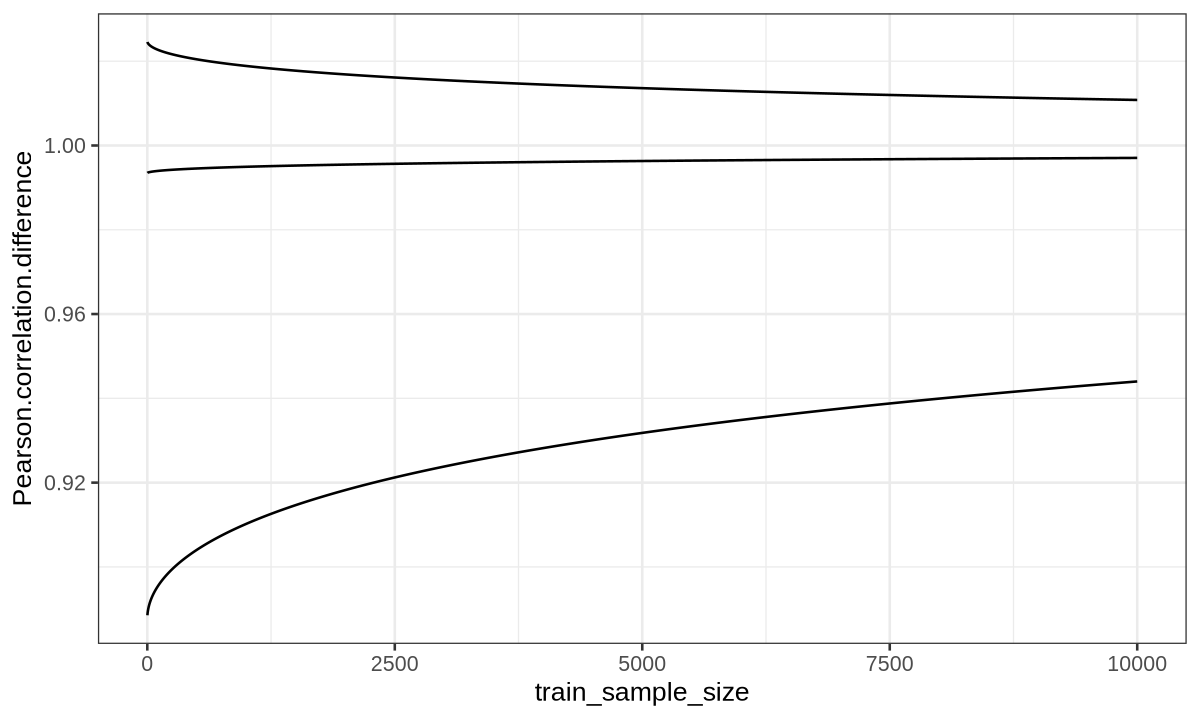

In [175]:
viz.df<-melt(r_pd_c %>% select(train_sample_size, RBF.norm, Polynomial.norm, ANN.norm), 
             id.vars = c('train_sample_size'), variable.name='model.type', 
            value.name='Pearson.correlation.difference')

ggplot(data = viz.df, 
       aes(x = train_sample_size, y = Pearson.correlation.difference, group = model.type)) + 
  geom_line()

In [176]:
figs = c(file.path(data_path, "figures", "power_analysis_barplots.png"),
file.path(data_path, "figures", "power_analysis_model_fits_all.png"),
file.path(data_path, "figures", "power_analysis_predictino_pearson.png"))

for (fig in figs){
    cmd = paste0('scp hmbaghda@orcd-login001.mit.edu:', fig, ' Downloads/mp_materials/mp_figures/.')
    print(cmd)
}

[1] "scp hmbaghda@orcd-login001.mit.edu:/home/hmbaghda/orcd/pool/metastatic_potential//figures/power_analysis_barplots.png Downloads/mp_materials/mp_figures/."
[1] "scp hmbaghda@orcd-login001.mit.edu:/home/hmbaghda/orcd/pool/metastatic_potential//figures/power_analysis_model_fits_all.png Downloads/mp_materials/mp_figures/."
[1] "scp hmbaghda@orcd-login001.mit.edu:/home/hmbaghda/orcd/pool/metastatic_potential//figures/power_analysis_predictino_pearson.png Downloads/mp_materials/mp_figures/."
